In [5]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=75ef69b211272d24febf780d86c690458d638bad261a01251618355995820b61
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=1b23c333aefdf13fdefb57c2bab67988c6bcb9b0ae88f84b2facaf4542b21878
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [6]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 35.8 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import segmentation_models_pytorch as smp
from sklearn.metrics import confusion_matrix
import cv2
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

In [8]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [9]:
# Define paths (adjust according to dataset location on Kaggle)
image_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset/train'
mask_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset/train'

In [10]:
# Collect image and mask paths
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
mask_files = [f.replace('_sat.jpg', '_mask.png') for f in image_files]

image_paths = [os.path.join(image_dir, f) for f in image_files]
mask_paths = [os.path.join(mask_dir, f) for f in mask_files]

# Verify that all masks exist
for mp in mask_paths:
    if not os.path.exists(mp):
        raise FileNotFoundError(f"Mask {mp} not found")

# Split into train and validation
indices = np.random.permutation(len(image_paths))
split = int(0.8 * len(indices))
train_indices = indices[:split]
val_indices = indices[split:]

In [11]:
train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]

In [12]:
# Define color to class mapping (adjust according to dataset documentation)
colors = np.array([
    [0, 255, 255],   # Urban land (0)
    [255, 255, 0],    # Agriculture (1)
    [255, 0, 255],    # Rangeland (2)
    [0, 255, 0],      # Forest (3)
    [0, 0, 255],      # Water (4)
    [255, 255, 255],  # Barren (5)
    [0, 0, 0]         # Unknown (6)
], dtype=np.uint8)

# Define transforms
transform_train = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

transform_val = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [13]:
class DeepGlobeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.colors = colors

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # ... (image loading code remains the same)
        image = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        mask_rgb = cv2.cvtColor(cv2.imread(self.mask_paths[idx]), cv2.COLOR_BGR2RGB)
        
        # Convert mask to class indices
        h, w = mask_rgb.shape[:2]
        mask_flat = mask_rgb.reshape(-1, 3)
        color_diff = np.abs(mask_flat[:, None, :] - self.colors[None, :, :])
        distance = np.sum(color_diff, axis=2)
        class_indices = np.argmin(distance, axis=1)
        class_mask = class_indices.reshape(h, w)

        if self.transform:
            transformed = self.transform(image=image, mask=class_mask)
            image = transformed['image']
            mask = transformed['mask'].long()  # Explicit cast to long
        else:
            image = A.ToTensorV2()(image=image)['image']
            mask = torch.from_numpy(class_mask).long()  # Already correct

        return image, mask

In [14]:
# Create datasets and dataloaders
train_dataset = DeepGlobeDataset(train_image_paths, train_mask_paths, transform_train)
val_dataset = DeepGlobeDataset(val_image_paths, val_mask_paths, transform_val)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# ---------- ASPP Module ----------
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        """
        Atrous Spatial Pyramid Pooling (ASPP)
        Args:
            in_channels: Number of input channels (e.g., 2048 from ResNet101)
            out_channels: Number of output channels for each branch (commonly 256)
            atrous_rates: List of dilation rates, e.g. [6, 12, 18]
        """
        super(ASPP, self).__init__()
        modules = []
        # 1x1 convolution branch
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ))
        # Atrous convolution branches
        for rate in atrous_rates:
            modules.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3,
                          padding=rate, dilation=rate, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        # Image pooling branch
        modules.append(nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ))
        self.convs = nn.ModuleList(modules)
        # Project the concatenated features
        self.project = nn.Sequential(
            nn.Conv2d(len(modules)*out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
    
    def forward(self, x):
        res = []
        # First branch: 1x1 conv and each atrous conv
        for conv in self.convs[:-1]:
            res.append(conv(x))
        # For image pooling branch: pool, then upsample to match x's spatial dims
        pool = self.convs[-1](x)
        pool = F.interpolate(pool, size=x.shape[2:], mode='bilinear', align_corners=False)
        res.append(pool)
        x = torch.cat(res, dim=1)
        return self.project(x)

# ---------- DeepLabV3Plus ----------
class DeepLabV3Plus(nn.Module):
    def __init__(self, n_classes, backbone='resnet101', pretrained=True):
        """
        DeepLabV3Plus model implemented from scratch.
        Args:
            n_classes: Number of segmentation classes
            backbone: Backbone network name ('resnet101' implemented here)
            pretrained: If True, load pretrained weights for the backbone
        """
        super(DeepLabV3Plus, self).__init__()
        if backbone == 'resnet101':
            resnet = models.resnet101(pretrained=pretrained)
        else:
            raise NotImplementedError("Only resnet101 backbone is implemented in this example.")
        
        # Use ResNet101 layers up to layer4.
        # layer0: conv1 + bn1 + relu + maxpool
        self.layer0 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.layer1 = resnet.layer1  # low-level features (typically 256 channels)
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4  # high-level features (2048 channels)
        
        # ASPP module on top of layer4
        self.aspp = ASPP(in_channels=2048, out_channels=256, atrous_rates=[6, 12, 18])
        
        # Low-level feature projection (from layer1) to reduce channels
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(256, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        
        # Decoder: fuse ASPP output with low-level features and produce final segmentation map
        self.decoder = nn.Sequential(
            nn.Conv2d(256 + 48, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, n_classes, kernel_size=1)
        )
    
    def forward(self, x):
        input_size = x.shape[2:]
        # Encoder: extract features
        x0 = self.layer0(x)
        x1 = self.layer1(x0)  # low-level features for decoder
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)  # high-level features
        
        # ASPP on high-level features
        x_aspp = self.aspp(x4)
        # Upsample ASPP output to match spatial size of low-level features
        x_aspp = F.interpolate(x_aspp, size=x1.shape[2:], mode='bilinear', align_corners=False)
        
        # Process low-level features
        low_level = self.low_level_conv(x1)
        
        # Concatenate and decode
        x_cat = torch.cat([x_aspp, low_level], dim=1)
        x_dec = self.decoder(x_cat)
        # Upsample to original image size
        x_dec = F.interpolate(x_dec, size=input_size, mode='bilinear', align_corners=False)
        return x_dec

# ---------------------------
# Example of setting up the model:
n_classes = 7  # For your 7 classes
model = DeepLabV3Plus(n_classes=n_classes, backbone='resnet101', pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 210MB/s] 


Using device: cuda


In [16]:
# # Model setup
# model = smp.DeepLabV3Plus(
#     encoder_name='resnet101',
#     encoder_weights='imagenet',
#     in_channels=3,
#     classes=7
# )
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# model = model.to(device)

In [17]:
# Loss and optimizer
ce_loss = nn.CrossEntropyLoss()
dice_loss = smp.losses.DiceLoss(mode='multiclass', classes=7)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
best_val_miou = 0.0

In [19]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_cm = np.zeros((7, 7), dtype=np.int64)
    
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss_ce = ce_loss(outputs, masks)
        loss_dice = dice_loss(outputs, masks)
        loss = loss_ce + loss_dice
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Update confusion matrix
        preds = torch.argmax(outputs.detach(), dim=1)
        masks_np = masks.cpu().numpy().flatten()
        preds_np = preds.cpu().numpy().flatten()
        cm = confusion_matrix(masks_np, preds_np, labels=range(7))
        total_cm += cm
    
    # Calculate metrics
    iou_per_class = []
    for i in range(7):
        tp = total_cm[i, i]
        fp = total_cm[:, i].sum() - tp
        fn = total_cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-9)
        iou_per_class.append(iou)
    miou = np.mean(iou_per_class)
    pixel_acc = np.diag(total_cm).sum() / total_cm.sum()
    
    print(f'Train Loss: {running_loss / len(train_loader):.4f}, mIoU: {miou:.4f}, Pixel Acc: {pixel_acc:.4f}')
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    val_total_cm = np.zeros((7, 7), dtype=np.int64)
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss_ce = ce_loss(outputs, masks)
            loss_dice = dice_loss(outputs, masks)
            loss = loss_ce + loss_dice
            val_running_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            masks_np = masks.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            cm = confusion_matrix(masks_np, preds_np, labels=range(7))
            val_total_cm += cm
    
    # Calculate validation metrics
    val_iou_per_class = []
    for i in range(7):
        tp = val_total_cm[i, i]
        fp = val_total_cm[:, i].sum() - tp
        fn = val_total_cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-9)
        val_iou_per_class.append(iou)
    val_miou = np.mean(val_iou_per_class)
    val_pixel_acc = np.diag(val_total_cm).sum() / val_total_cm.sum()
    
    print(f'Val Loss: {val_running_loss / len(val_loader):.4f}, Val mIoU: {val_miou:.4f}, Val Pixel Acc: {val_pixel_acc:.4f}')
    
    # Save best model
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        print(f'Best model saved with mIoU: {best_val_miou:.4f}')

print('Training Complete!')

Epoch 1/20 - Training: 100%|██████████| 81/81 [10:01<00:00,  7.42s/it]


Train Loss: 1.5882, mIoU: 0.3660, Pixel Acc: 0.7136


Epoch 1/20 - Validation: 100%|██████████| 21/21 [02:28<00:00,  7.09s/it]


Val Loss: 1.2176, Val mIoU: 0.4745, Val Pixel Acc: 0.8067
Best model saved with mIoU: 0.4745


Epoch 2/20 - Training: 100%|██████████| 81/81 [10:01<00:00,  7.42s/it]


Train Loss: 1.1739, mIoU: 0.4716, Pixel Acc: 0.7988


Epoch 2/20 - Validation: 100%|██████████| 21/21 [02:24<00:00,  6.89s/it]


Val Loss: 0.9682, Val mIoU: 0.5383, Val Pixel Acc: 0.8409
Best model saved with mIoU: 0.5383


Epoch 3/20 - Training: 100%|██████████| 81/81 [09:55<00:00,  7.36s/it]


Train Loss: 1.0945, mIoU: 0.4994, Pixel Acc: 0.8022


Epoch 3/20 - Validation: 100%|██████████| 21/21 [02:25<00:00,  6.95s/it]


Val Loss: 0.9563, Val mIoU: 0.5303, Val Pixel Acc: 0.8320


Epoch 4/20 - Training: 100%|██████████| 81/81 [09:54<00:00,  7.33s/it]


Train Loss: 1.0226, mIoU: 0.5161, Pixel Acc: 0.8155


Epoch 4/20 - Validation: 100%|██████████| 21/21 [02:26<00:00,  6.97s/it]


Val Loss: 0.9155, Val mIoU: 0.5343, Val Pixel Acc: 0.8425


Epoch 5/20 - Training: 100%|██████████| 81/81 [09:52<00:00,  7.31s/it]


Train Loss: 0.9393, mIoU: 0.5382, Pixel Acc: 0.8293


Epoch 5/20 - Validation: 100%|██████████| 21/21 [02:23<00:00,  6.85s/it]


Val Loss: 0.9636, Val mIoU: 0.5505, Val Pixel Acc: 0.8370
Best model saved with mIoU: 0.5505


Epoch 6/20 - Training: 100%|██████████| 81/81 [09:50<00:00,  7.29s/it]


Train Loss: 0.8781, mIoU: 0.5872, Pixel Acc: 0.8511


Epoch 6/20 - Validation: 100%|██████████| 21/21 [02:24<00:00,  6.90s/it]


Val Loss: 0.8445, Val mIoU: 0.5808, Val Pixel Acc: 0.8573
Best model saved with mIoU: 0.5808


Epoch 7/20 - Training: 100%|██████████| 81/81 [09:53<00:00,  7.33s/it]


Train Loss: 0.9002, mIoU: 0.6051, Pixel Acc: 0.8454


Epoch 7/20 - Validation: 100%|██████████| 21/21 [02:23<00:00,  6.85s/it]


Val Loss: 0.8766, Val mIoU: 0.5722, Val Pixel Acc: 0.8568


Epoch 8/20 - Training: 100%|██████████| 81/81 [09:46<00:00,  7.24s/it]


Train Loss: 0.8623, mIoU: 0.6290, Pixel Acc: 0.8529


Epoch 8/20 - Validation: 100%|██████████| 21/21 [02:24<00:00,  6.90s/it]


Val Loss: 0.8462, Val mIoU: 0.6029, Val Pixel Acc: 0.8574
Best model saved with mIoU: 0.6029


Epoch 9/20 - Training: 100%|██████████| 81/81 [09:46<00:00,  7.25s/it]


Train Loss: 0.8105, mIoU: 0.6544, Pixel Acc: 0.8587


Epoch 9/20 - Validation: 100%|██████████| 21/21 [02:24<00:00,  6.90s/it]


Val Loss: 0.7851, Val mIoU: 0.6321, Val Pixel Acc: 0.8724
Best model saved with mIoU: 0.6321


Epoch 10/20 - Training: 100%|██████████| 81/81 [09:45<00:00,  7.23s/it]


Train Loss: 0.7996, mIoU: 0.6540, Pixel Acc: 0.8605


Epoch 10/20 - Validation: 100%|██████████| 21/21 [02:22<00:00,  6.78s/it]


Val Loss: 0.8160, Val mIoU: 0.6226, Val Pixel Acc: 0.8626


Epoch 11/20 - Training: 100%|██████████| 81/81 [09:52<00:00,  7.32s/it]


Train Loss: 0.8192, mIoU: 0.6511, Pixel Acc: 0.8581


Epoch 11/20 - Validation: 100%|██████████| 21/21 [02:23<00:00,  6.85s/it]


Val Loss: 0.7824, Val mIoU: 0.6544, Val Pixel Acc: 0.8633
Best model saved with mIoU: 0.6544


Epoch 12/20 - Training: 100%|██████████| 81/81 [09:51<00:00,  7.30s/it]


Train Loss: 0.7261, mIoU: 0.7002, Pixel Acc: 0.8770


Epoch 12/20 - Validation: 100%|██████████| 21/21 [02:25<00:00,  6.93s/it]


Val Loss: 0.7916, Val mIoU: 0.6553, Val Pixel Acc: 0.8684
Best model saved with mIoU: 0.6553


Epoch 13/20 - Training: 100%|██████████| 81/81 [09:47<00:00,  7.25s/it]


Train Loss: 0.7422, mIoU: 0.6936, Pixel Acc: 0.8746


Epoch 13/20 - Validation: 100%|██████████| 21/21 [02:23<00:00,  6.84s/it]


Val Loss: 0.8067, Val mIoU: 0.6348, Val Pixel Acc: 0.8696


Epoch 14/20 - Training: 100%|██████████| 81/81 [09:50<00:00,  7.29s/it]


Train Loss: 0.7220, mIoU: 0.7034, Pixel Acc: 0.8806


Epoch 14/20 - Validation: 100%|██████████| 21/21 [02:25<00:00,  6.91s/it]


Val Loss: 0.8227, Val mIoU: 0.6385, Val Pixel Acc: 0.8592


Epoch 15/20 - Training: 100%|██████████| 81/81 [09:51<00:00,  7.30s/it]


Train Loss: 0.6667, mIoU: 0.6860, Pixel Acc: 0.8881


Epoch 15/20 - Validation: 100%|██████████| 21/21 [02:25<00:00,  6.93s/it]


Val Loss: 0.7932, Val mIoU: 0.6409, Val Pixel Acc: 0.8628


Epoch 16/20 - Training: 100%|██████████| 81/81 [09:50<00:00,  7.29s/it]


Train Loss: 0.6298, mIoU: 0.7310, Pixel Acc: 0.8960


Epoch 16/20 - Validation: 100%|██████████| 21/21 [02:24<00:00,  6.88s/it]


Val Loss: 0.7806, Val mIoU: 0.6457, Val Pixel Acc: 0.8639


Epoch 17/20 - Training: 100%|██████████| 81/81 [09:48<00:00,  7.27s/it]


Train Loss: 0.7044, mIoU: 0.7007, Pixel Acc: 0.8798


Epoch 17/20 - Validation: 100%|██████████| 21/21 [02:24<00:00,  6.87s/it]


Val Loss: 0.8092, Val mIoU: 0.6414, Val Pixel Acc: 0.8584


Epoch 18/20 - Training: 100%|██████████| 81/81 [09:50<00:00,  7.29s/it]


Train Loss: 0.7202, mIoU: 0.7013, Pixel Acc: 0.8795


Epoch 18/20 - Validation: 100%|██████████| 21/21 [02:23<00:00,  6.84s/it]


Val Loss: 0.7977, Val mIoU: 0.6478, Val Pixel Acc: 0.8710


Epoch 19/20 - Training: 100%|██████████| 81/81 [09:46<00:00,  7.24s/it]


Train Loss: 0.6412, mIoU: 0.7391, Pixel Acc: 0.8943


Epoch 19/20 - Validation: 100%|██████████| 21/21 [02:23<00:00,  6.82s/it]


Val Loss: 0.7531, Val mIoU: 0.6616, Val Pixel Acc: 0.8756
Best model saved with mIoU: 0.6616


Epoch 20/20 - Training: 100%|██████████| 81/81 [09:49<00:00,  7.27s/it]


Train Loss: 0.6293, mIoU: 0.7315, Pixel Acc: 0.8960


Epoch 20/20 - Validation: 100%|██████████| 21/21 [02:25<00:00,  6.94s/it]

Val Loss: 0.7529, Val mIoU: 0.6509, Val Pixel Acc: 0.8730
Training Complete!


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, device, colors, num_samples=3):
    """
    Visualize original image, ground truth mask, and predicted mask
    Args:
        model: Trained model
        dataset: Dataset object (e.g., val_dataset)
        device: cuda/cpu
        colors: Color mapping array
        num_samples: Number of samples to visualize
    """
    model.eval()
    indices = np.random.choice(len(dataset), num_samples)
    
    plt.figure(figsize=(18, 4*num_samples))
    
    for i, idx in enumerate(indices):
        # Get data
        image, true_mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        
        # Prediction
        with torch.no_grad():
            output = model(image_tensor)
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
        
        # Convert image to display format
        image = image.cpu().numpy().transpose(1, 2, 0)
        image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        image = image.astype(np.uint8)
        
        # Convert masks to RGB
        def mask_to_rgb(mask_array):
            h, w = mask_array.shape
            rgb = np.zeros((h, w, 3), dtype=np.uint8)
            for class_idx, color in enumerate(colors):
                rgb[mask_array == class_idx] = color
            return rgb
            
        true_mask_rgb = mask_to_rgb(true_mask.numpy())
        pred_mask_rgb = mask_to_rgb(pred_mask)
        
        # Plot
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(image)
        plt.title(f"Sample {i+1}\nOriginal Image")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(true_mask_rgb)
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(pred_mask_rgb)
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [21]:
# Define colors (must match your dataset's class order)
colors = np.array([
    [0, 255, 255],   # Urban land
    [255, 255, 0],   # Agriculture
    [255, 0, 255],   # Rangeland
    [0, 255, 0],     # Forest
    [0, 0, 255],     # Water
    [255, 255, 255], # Barren
    [0, 0, 0]        # Unknown
])

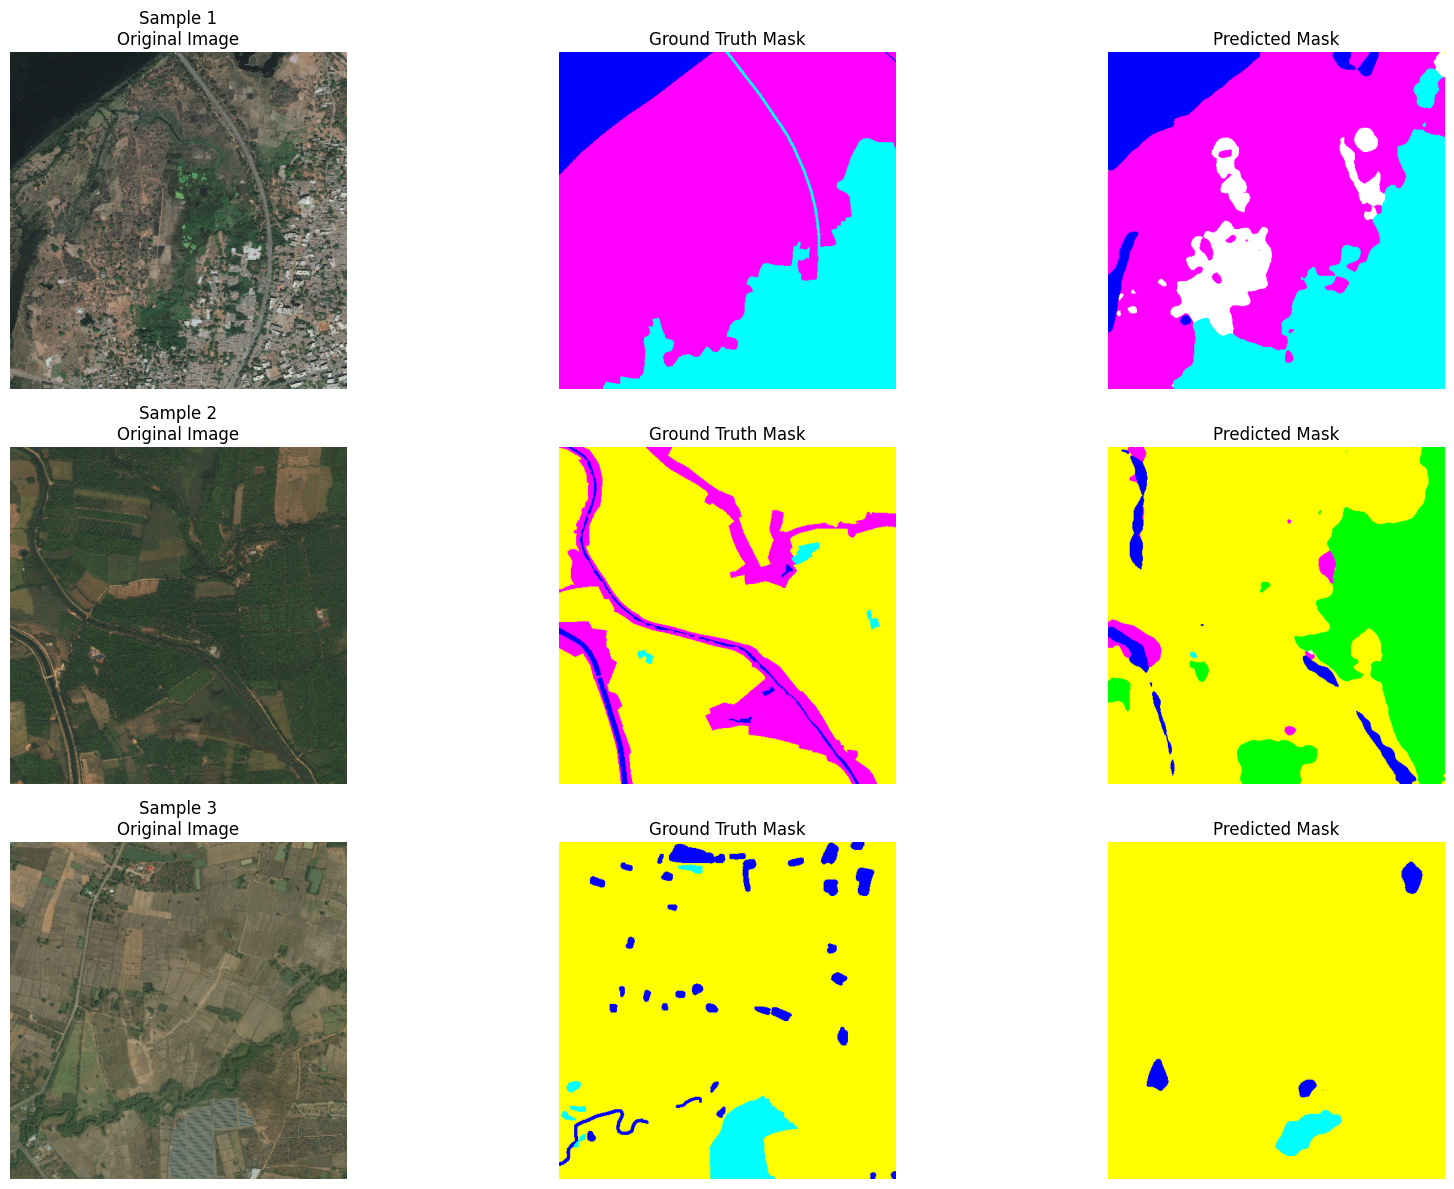

In [22]:
# Usage after training
visualize_predictions(
    model=model,
    dataset=val_dataset,  # Use your validation dataset
    device=device,
    colors=colors,
    num_samples=3  # Number of examples to show
)

In [25]:
def evaluate_model(model_path, val_loader, device):
    # Load best model
    n_classes = 7  # For your 7 classes
    model = DeepLabV3Plus(n_classes=n_classes, backbone='resnet101', pretrained=True)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    # Initialize metrics
    dice_loss = smp.losses.DiceLoss(mode='multiclass', classes=7)
    total_dice = 0.0
    total_cm = np.zeros((7, 7), dtype=np.int64)
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # Calculate Dice Loss
            loss_dice = dice_loss(outputs, masks)
            total_dice += loss_dice.item()
            
            # For other metrics
            preds = torch.argmax(outputs, dim=1)
            masks_np = masks.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            cm = confusion_matrix(masks_np, preds_np, labels=range(7))
            total_cm += cm
    
    # Calculate metrics
    val_dice = total_dice / len(val_loader)
    
    val_iou_per_class = []
    for i in range(7):
        tp = total_cm[i, i]
        fp = total_cm[:, i].sum() - tp
        fn = total_cm[i, :].sum() - tp
        iou = tp / (tp + fp + fn + 1e-9)
        val_iou_per_class.append(iou)
    val_miou = np.mean(val_iou_per_class)
    val_pixel_acc = np.diag(total_cm).sum() / total_cm.sum()
    
    print(f"\nFinal Evaluation Results:")
    print(f"Dice Loss: {val_dice:.4f}")
    print(f"mIoU: {val_miou:.4f}")
    print(f"Pixel Accuracy: {val_pixel_acc:.4f}")

# Usage
evaluate_model(
    model_path='/kaggle/working/best_model.pth',
    val_loader=val_loader,
    device=device
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-25-0a7b77f97d81>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta


Final Evaluation Results:
Dice Loss: 0.3673
mIoU: 0.6616
Pixel Accuracy: 0.8756
